"""
Process Pavitra Emissions and Validation Dataset
This file works on datasets previously modified using nco in a ubuntu machine
@author: lucarojasmendoza
last modified: 2024-01-30
"""

In [2]:
#import packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import box
from shapely.geometry import Point
from datetime import datetime
import os
from time import time
from cmcrameri import cm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr

#This is code that needs to be improved and cannot be assumed to be accurate. There may be errors in the code
#Please do not use this code to process emissions files without having a clear understanding of what each line of 
#code is exactly doing.
%run process_pavitra_emissions.py

In [3]:
source_crs = "+proj=merc +units=m +a=6370000.0 +b=6370000.0 +lon_0=80.0 +lat_ts=15.0 +no_defs"

# Convert Emissions to Shapefile (Except VOCs)

In [14]:
# Define a list of pollutants
#original file name was SO2
pollutants = ['NH3', 'BC', 'MM', 'NOx', 'OC', 'SOx']

# Loop through each pollutant
for pollutant in pollutants:
    netcdf_file_path = f'/Volumes/lrojasm/2019_emissions_ground_elevated/{pollutant}_anthro_201901-201912_merged_average.nc'
    variable_names = ['ground', 'ene']
    output_path = f'Processed_Emissions_2019_Pavitra/{pollutant}_2019_ground_elevated.shp'
    
    # Check if the netCDF file exists
    if os.path.exists(netcdf_file_path):
        # Process and save the data
        process_netCDF_and_save(netcdf_file_path, variable_names, pollutant, output_path)
    else:
        print(f"File not found: {netcdf_file_path}")

# Process VOC Emissions

In [15]:
# Define a list of pollutants
pollutants = ['OL2', 'OLI', 'OLT', 'ORA1', 'ORA2', 'TOL','XYL','ETH','HC3','HC5','HC8','HCHO','ISO','KET','ALD']

# Loop through each pollutant
#Files were created using bash.
for pollutant in pollutants:
    netcdf_file_path = f'/Volumes/lrojasm/2019_emissions_ground_elevated/{pollutant}_anthro_COALESCE_201501-201512_average.nc'    
    variable_names = ['ground', 'ene']
    output_path = f'Processed_Emissions_2019_Pavitra/{pollutant}_2015_VOC_ground_elevated.shp'
    
    # Check if the netCDF file exists
    if os.path.exists(netcdf_file_path):
        # Process and save the data
        process_netCDF_and_save(netcdf_file_path, variable_names, pollutant, output_path)
    else:
        print(f"File not found: {netcdf_file_path}")

In [16]:
# List of pollutants
pollutants = ['OL2', 'OLI', 'OLT', 'ORA1', 'ORA2', 'TOL', 'XYL', 'ETH', 'HC3', 'HC5', 'HC8', 'HCHO', 'ISO', 'KET', 'ALD']

# Initialize the combined GeoDataFrame using the first pollutant
first_pollutant = pollutants[0]
combined_gdf = gpd.read_file(f'Processed_Emissions_2019_Pavitra/{first_pollutant}_2015_VOC_ground_elevated.shp')

# List to store 'pollutant' arrays
pollutant_arrays = [combined_gdf[pollutants[0]].values]

# Loop through the remaining pollutants and load their 'pollutant' arrays
for pollutant in pollutants[1:]:
    file_path = f'Processed_Emissions_2019_Pavitra/{pollutant}_2015_VOC_ground_elevated.shp'
    if os.path.exists(file_path):
        gdf = gpd.read_file(file_path)
        pollutant_arrays.append(gdf[pollutant].values)

# Add a 'VOC' column by summing up the pollutant arrays
# verify axis 
combined_gdf['VOC'] = np.sum(pollutant_arrays, axis=0)

# Drop the 'pollutant' column from the first pollutant
combined_gdf = combined_gdf.drop(columns=[pollutants[0]])

# Save the combined GeoDataFrame to a new shapefile
combined_gdf.to_file('Processed_Emissions_2019_Pavitra/2015_VOC_ground_elevated.shp')

# Merge all Emissions (We won't add the VOC file or PM2.5)

* NOx = NOx
* NH3 = NH3
* SOx = SO2
* BC, OC and MM remain as independent columns
* PM2.5 = BC (Separate Files)
          1.9*OC (Separate Files)
          MM     (Separate Files)
          (Dust should also be added as PM2.5)

In [18]:
# Define a list of pollutants
pollutants = ['NH3', 'NOx','SOx']

# Initialize the combined GeoDataFrame using the first pollutant
first_pollutant = pollutants[0]
combined_gdf = gpd.read_file(f'Processed_Emissions_2019_Pavitra/{first_pollutant}_2019_ground_elevated.shp')

# Iterate through the remaining pollutants and add their data as new columns
for pollutant in pollutants[1:]:
    file_path = f'Processed_Emissions_2019_Pavitra/{pollutant}_2019_ground_elevated.shp'
    try:
        pollutant_gdf = gpd.read_file(file_path)
        combined_gdf[pollutant] = pollutant_gdf[pollutant].values
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

# Save the combined GeoDataFrame to a new shapefile
combined_gdf.to_file('Processed_Emissions_2019_Pavitra/NH3_NOx_SOx_2019_ground_elevated.shp')

In [19]:
combined_gdf.head()

,height,NH3,geometry,NOx,SOx
0,0,6.457000e-12,POINT (39.00000 -12.90000),2.132000e-11,3.086000e-12
1,0,6.087000e-12,POINT (39.05000 -12.90000),1.946700e-11,2.831000e-12
2,0,5.714000e-12,POINT (39.10000 -12.90000),1.761300e-11,2.576000e-12
3,0,5.597000e-12,POINT (39.15000 -12.90000),1.753100e-11,2.539000e-12
4,0,5.736000e-12,POINT (39.20000 -12.90000),1.922000e-11,2.719000e-12


In [20]:
# Define a list of pollutants
pollutants=['OC','BC','MM']

# Initialize the combined GeoDataFrame using the first pollutant
for pollutant in pollutants:
    pollutant_gdf = gpd.read_file(f'Processed_Emissions_2019_Pavitra/{pollutant}_2019_ground_elevated.shp')
    if pollutant=='OC':
        pollutant_gdf['PM2_5'] = pollutant_gdf.eval('1.9 * OC')
    elif pollutant=='BC':
        pollutant_gdf['PM2_5'] = pollutant_gdf.eval('BC')
    else:
        pollutant_gdf['PM2_5'] = pollutant_gdf.eval('MM')
        # Save the combined GeoDataFrame to a new shapefile
    pollutant_gdf.to_file(f'Processed_Emissions_2019_Pavitra/{pollutant}_PM2_5_2019_ground_elevated.shp')

# Convert to mercator and from kg/m2/second to kg/year (except VOCs).

In [4]:
# Define the multiplication factor
factor = 365 * 24 * 3600 * 0.05 * 0.05 * 111 * 111 * 1e6

# Define a list of pollutants (file names)
pollutants = ['NH3_NOx_SOx','BC_PM2_5','MM_PM2_5','OC_PM2_5']


# Iterate through the pollutants
for pollutant in pollutants:
    input_file_path = f'Processed_Emissions_2019_Pavitra/{pollutant}_2019_ground_elevated.shp'
    output_file_path = f'Processed_Emissions_2019_Pavitra/{pollutant}_2019_ground_elevated_mercator_kg_year.shp'
    
    # Read the original shapefile
    pollutant_gdf = gpd.read_file(input_file_path)
    
    # Print the original CRS
    original_crs = pollutant_gdf.crs
    print(f"Original CRS of {input_file_path}: {original_crs}")
    
    # Exclude 'height' and 'geometry' columns, and multiply the rest by the factor
    columns_to_multiply = [col for col in pollutant_gdf.columns if col not in ['height', 'geometry']]
    pollutant_gdf[columns_to_multiply] = pollutant_gdf[columns_to_multiply] * factor
    
    # Change the projection
    pollutant_gdf = pollutant_gdf.to_crs(source_crs)
    
    # Save the GeoDataFrame to a new shapefile with the new name and projection
    pollutant_gdf.to_file(output_file_path)
    
    print(f"Converted and saved {input_file_path} to {output_file_path}")

Original CRS of Processed_Emissions_2019_Pavitra/NH3_NOx_SOx_2019_ground_elevated.shp: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
Converted and saved Processed_Emissions_2019_Pavitra/NH3_NOx_SOx_2019_ground_elevated.shp to Processed_Emissions_2019_Pavitra/NH3_NOx_SOx_2019_ground_elevated_mercator_kg_year.shp
Original CRS of Processed_Emissions_2019_Pavitra/BC_PM2_5_2019_ground_elevated.shp: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
Converted and saved Processed_Emissions_2019_Pavitra/BC_PM2_5_2019_ground_elevated.shp to Processed_Emissions_2019_Pavitra/BC_PM2_5_2019_ground_elevated_mercator_kg_year.shp
Original CRS of Pro

In [10]:
Pollutants_gdf = gpd.read_file('Processed_Emissions_2019_Pavitra/NH3_NOx_SOx_2019_ground_elevated_mercator_kg_year.shp')
Pollutants_gdf[['NH3','NOx','SOx']].sum()

NH3    3.320035e+10
NOx    5.756363e+10
SOx    4.228219e+10
dtype: float64

In [12]:
BC_gdf = gpd.read_file('Processed_Emissions_2019_Pavitra/BC_PM2_5_2019_ground_elevated_mercator_kg_year.shp')
BC_gdf[['PM2_5']].sum()

PM2_5    3.846525e+09
dtype: float64

In [13]:
MM_gdf = gpd.read_file('Processed_Emissions_2019_Pavitra/OC_PM2_5_2019_ground_elevated_mercator_kg_year.shp')
MM_gdf[['PM2_5']].sum()

PM2_5    2.205811e+10
dtype: float64

In [14]:
OC_gdf = gpd.read_file('Processed_Emissions_2019_Pavitra/MM_PM2_5_2019_ground_elevated_mercator_kg_year.shp')
OC_gdf[['PM2_5']].sum()

PM2_5    3.926786e+09
dtype: float64

# Convert to mercator and from kg/m2/second to kg/year (VOCs)

In [25]:
VOC_gdf = gpd.read_file('Processed_Emissions_2019_Pavitra/2015_VOC_ground_elevated.shp')
VOC_gdf.head()

,height,VOC,geometry
0,0,5.533000e-11,POINT (39.00000 -13.00000)
1,0,5.310000e-11,POINT (39.25000 -13.00000)
2,0,6.119900e-11,POINT (39.50000 -13.00000)
3,0,6.928900e-11,POINT (39.75000 -13.00000)
4,0,6.797800e-11,POINT (40.00000 -13.00000)


In [26]:
VOC_gdf[['VOC']].sum()

VOC    0.000005
dtype: float64

In [37]:
#Increase resolution.
#This step converts from 0.25*0.25 (points) to 0.05*0.05 (25 points), effectively increasing resolution of VOC emissions
input_file_path = 'Processed_Emissions_2019_Pavitra/2015_VOC_ground_elevated.shp'
output_file_path = 'Processed_Emissions_2019_Pavitra/VOC_2015_ground_elevated.shp'
increase_resolution_VOC(input_file_path, output_file_path)

,height,VOC,geometry
0,0,5.533000e-11,POINT (38.90000 -13.10000)
1,0,5.533000e-11,POINT (38.90000 -13.05000)
2,0,5.533000e-11,POINT (38.90000 -13.00000)
3,0,5.533000e-11,POINT (38.90000 -12.95000)
4,0,5.533000e-11,POINT (38.90000 -12.90000)


In [38]:
VOC_gdf = gpd.read_file('Processed_Emissions_2019_Pavitra/VOC_2015_ground_elevated.shp')
VOC_gdf.head()

,height,VOC,geometry
0,0,5.533000e-11,POINT (38.90000 -13.10000)
1,0,5.533000e-11,POINT (38.90000 -13.05000)
2,0,5.533000e-11,POINT (38.90000 -13.00000)
3,0,5.533000e-11,POINT (38.90000 -12.95000)
4,0,5.533000e-11,POINT (38.90000 -12.90000)


In [39]:
# Define the multiplication factor
factor = 365 * 24 * 3600 * 0.05 * 0.05* 111 * 111 * 1e6
# Define a list of pollutants (file names)
pollutants = ['VOC_2015']
# Iterate through the pollutants
for pollutant in pollutants:
    input_file_path = f'Processed_Emissions_2019_Pavitra/{pollutant}_ground_elevated.shp'
    output_file_path = f'Processed_Emissions_2019_Pavitra/{pollutant}_ground_elevated_mercator_kg_year.shp'  
    
    # Read the original shapefile
    pollutant_gdf = gpd.read_file(input_file_path)
    
    # Print the original CRS
    original_crs = pollutant_gdf.crs
    print(f"Original CRS of {input_file_path}: {original_crs}")
    
    # Exclude 'height' and 'geometry' columns, and multiply the rest by the factor
    columns_to_multiply = [col for col in pollutant_gdf.columns if col not in ['height', 'geometry']]
    pollutant_gdf[columns_to_multiply] = pollutant_gdf[columns_to_multiply] * factor
    
    # Change the projection
    pollutant_gdf = pollutant_gdf.to_crs(source_crs)
    
    # Save the GeoDataFrame to a new shapefile with the new name and projection
    pollutant_gdf.to_file(output_file_path)
    
    print(f"Converted and saved {input_file_path} to {output_file_path}")

Original CRS of Processed_Emissions_2019_Pavitra/VOC_2015_ground_elevated.shp: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
Converted and saved Processed_Emissions_2019_Pavitra/VOC_2015_ground_elevated.shp to Processed_Emissions_2019_Pavitra/VOC_2015_ground_elevated_mercator_kg_year.shp


In [40]:
VOC_gdf = gpd.read_file('Processed_Emissions_2019_Pavitra/VOC_2015_ground_elevated_mercator_kg_year.shp')
VOC_gdf[['VOC']].sum()

VOC    1.095625e+11
dtype: float64

In [41]:
VOC_gdf

,height,VOC,geometry
0,0,53746.878121,POINT (-4413695.825 -1419217.906)
1,0,53746.878121,POINT (-4413695.825 -1413705.536)
2,0,53746.878121,POINT (-4413695.825 -1408194.282)
3,0,53746.878121,POINT (-4413695.825 -1402684.138)
4,0,53746.878121,POINT (-4413695.825 -1397175.099)
...,...,...,...
3514495,100,20118.409412,POINT (4440543.123 4680134.631)
3514496,100,20118.409412,POINT (4440543.123 4687136.279)
3514497,100,20118.409412,POINT (4440543.123 4694143.047)
3514498,100,20118.409412,POINT (4440543.123 4701154.947)


# Process INline Dust Emissions (in g/m2/s)

In [103]:
netcdf_file_path = '/Volumes/lrojasm/2019_emissions_ground_elevated/Dust_year_average_240129.nc'
variable_names = ['EDUST']
pollutant = 'PM2_5'
output_path = 'Processed_Emissions_2019_Pavitra/inline_dust_2017.shp'
process_netCDF_dust_and_save_2(netcdf_file_path, variable_names, pollutant, output_path, input_crs="EPSG:4326", target_crs=None)

,geometry,PM2_5
0,POINT (39.01822 -12.87517),0.0
1,POINT (39.26964 -12.87517),0.0
2,POINT (39.52106 -12.87517),0.0
3,POINT (39.77249 -12.87517),0.0
4,POINT (40.02391 -12.87517),0.0


In [104]:
dust_gdf = gpd.read_file('Processed_Emissions_2019_Pavitra/inline_dust_2017.shp')
dust_gdf[['PM2_5']].sum()

PM2_5    0.002087
dtype: float64

In [105]:
# Define the multiplication factor
#Units for dust are g/m2/s
factor = 365 * 24 * 0.25 *0.25*111*111*1e6*0.001 #because we have grams and want kg

# Define a list of pollutants (file names)
pollutants = ['inline_dust_2017']

# Iterate through the pollutants
for pollutant in pollutants:
    input_file_path = f'Processed_Emissions_2019_Pavitra/{pollutant}.shp'
    output_file_path = f'Processed_Emissions_2019_Pavitra/{pollutant}_ground_elevated_mercator_kg_year.shp'  
    
    # Read the original shapefile
    pollutant_gdf = gpd.read_file(input_file_path)
    
    # Print the original CRS
    original_crs = pollutant_gdf.crs
    print(f"Original CRS of {input_file_path}: {original_crs}")
    
    # Exclude 'height' and 'geometry' columns, and multiply the rest by the factor
    columns_to_multiply = [col for col in pollutant_gdf.columns if col not in ['height', 'geometry']]
    pollutant_gdf[columns_to_multiply] = pollutant_gdf[columns_to_multiply] * factor
    
    # Change the projection
    pollutant_gdf = pollutant_gdf.to_crs(source_crs)
    
    # Save the GeoDataFrame to a new shapefile with the new name and projection
    pollutant_gdf.to_file(output_file_path)
    
    print(f"Converted and saved {input_file_path} to {output_file_path}")

Original CRS of Processed_Emissions_2019_Pavitra/inline_dust_2017.shp: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
Converted and saved Processed_Emissions_2019_Pavitra/inline_dust_2017.shp to Processed_Emissions_2019_Pavitra/inline_dust_2017_ground_elevated_mercator_kg_year.shp


In [106]:
dust_gdf = gpd.read_file('Processed_Emissions_2019_Pavitra/inline_dust_2017_ground_elevated_mercator_kg_year.shp')
dust_gdf[['PM2_5']].sum()

PM2_5    1.407540e+07
dtype: float64

# Validation Files

# Process WRF-CHEM GROUND Baselines

In [53]:
#process BC
netcdf_file_path = '/Volumes/lrojasm/2017_validation_data/sconcbc_validation_year.nc'
variable_names = ['sconcbc']
pollutant = 'BC'
output_path = 'Processed_Emissions_2019_Pavitra/Validation_Data/BC_2017_WRF.shp'
process_netCDF_wrfground_and_save(netcdf_file_path, variable_names, pollutant, output_path, input_crs="EPSG:4326", target_crs=None)

,geometry,BC
0,POINT (39.01822 -12.87517),2.065551e-10
1,POINT (39.26965 -12.87517),1.999942e-10
2,POINT (39.52106 -12.87517),2.003021e-10
3,POINT (39.77249 -12.87517),2.017464e-10
4,POINT (40.02391 -12.87517),2.072405e-10


In [9]:
# Define a dictionary of pollutant names and their corresponding file name parts
pollutants = {
    'BC': 'sconcbc',
    'Cl': 'sconccl',
    'Dust': 'sconcdust',
    'Na': 'sconcna',
    'NH4': 'sconcnh4',
    'NO3': 'sconcno3',
    'SO4': 'sconcso4',
    'POA': 'sconcpoa'
}

# Iterate through the pollutants and process the corresponding files
for pollutant, conc_pollutant in pollutants.items():
    # Construct the file path based on the pollutant name
    netcdf_file_path = f'/Volumes/lrojasm/2017_validation_data/{conc_pollutant}_validation_year.nc'
    # Modify the output path based on the pollutant name
    output_path = f'Validation_Data/{pollutant}_2017_WRF.shp'
    
    # Process and plot data with the updated file and output paths
    variable_name = [conc_pollutant]  # Assuming variable_names is defined elsewhere
    # Check if the netCDF file exists
    if os.path.exists(netcdf_file_path):
        process_netCDF_wrfground_and_save(netcdf_file_path, variable_name, pollutant, output_path, input_crs="EPSG:4326", target_crs=None)
    else:
        print(f"File not found: {netcdf_file_path}")

In [10]:
#merge all files into one single file 
# Define a list of pollutants
pollutants = ['BC', 'Cl', 'Dust', 'Na', 'NH4', 'NO3','SO4','POA']

# Initialize the combined GeoDataFrame using the first pollutant
first_pollutant = pollutants[0]
combined_gdf = gpd.read_file(f'Validation_Data/{first_pollutant}_2017_WRF.shp')

# Iterate through the remaining pollutants and add their data as new columns
for pollutant in pollutants[1:]:
    file_path = f'Validation_Data/{pollutant}_2017_WRF.shp'
    try:
        pollutant_gdf = gpd.read_file(file_path)
        combined_gdf[pollutant] = pollutant_gdf[pollutant].values
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

# Save the combined GeoDataFrame to a new shapefile
combined_gdf.to_file('Validation_Data/2017_WRF_ground_combined.shp')

In [11]:
#Convert from kg/m3 to ug/m3 and to mercator. 
# Define the multiplication factor
factor =1e9

# Define the new projection you want to use

input_file_path = 'Validation_Data/2017_WRF_ground_combined.shp'
output_file_path = 'Validation_Data/2017_WRF_ground_combined_ug_m3_mercator.shp'
    
# Read the original shapefile
pollutant_gdf = gpd.read_file(input_file_path)
    
# Print the original CRS
original_crs = pollutant_gdf.crs
print(f"Original CRS of {input_file_path}: {original_crs}")
    
# Exclude 'height' and 'geometry' columns, and multiply the rest by the factor
columns_to_multiply = [col for col in pollutant_gdf.columns if col not in ['height', 'geometry']]
pollutant_gdf[columns_to_multiply] = pollutant_gdf[columns_to_multiply] * factor
    
# Change the projection
pollutant_gdf = pollutant_gdf.to_crs(source_crs)
    
# Save the GeoDataFrame to a new shapefile with the new name and projection
pollutant_gdf.to_file(output_file_path)
    
print(f"Converted and saved {input_file_path} to {output_file_path}")

Original CRS of Validation_Data/2017_WRF_ground_combined.shp: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
Converted and saved Validation_Data/2017_WRF_ground_combined.shp to Validation_Data/2017_WRF_ground_combined_ug_m3_mercator.shp


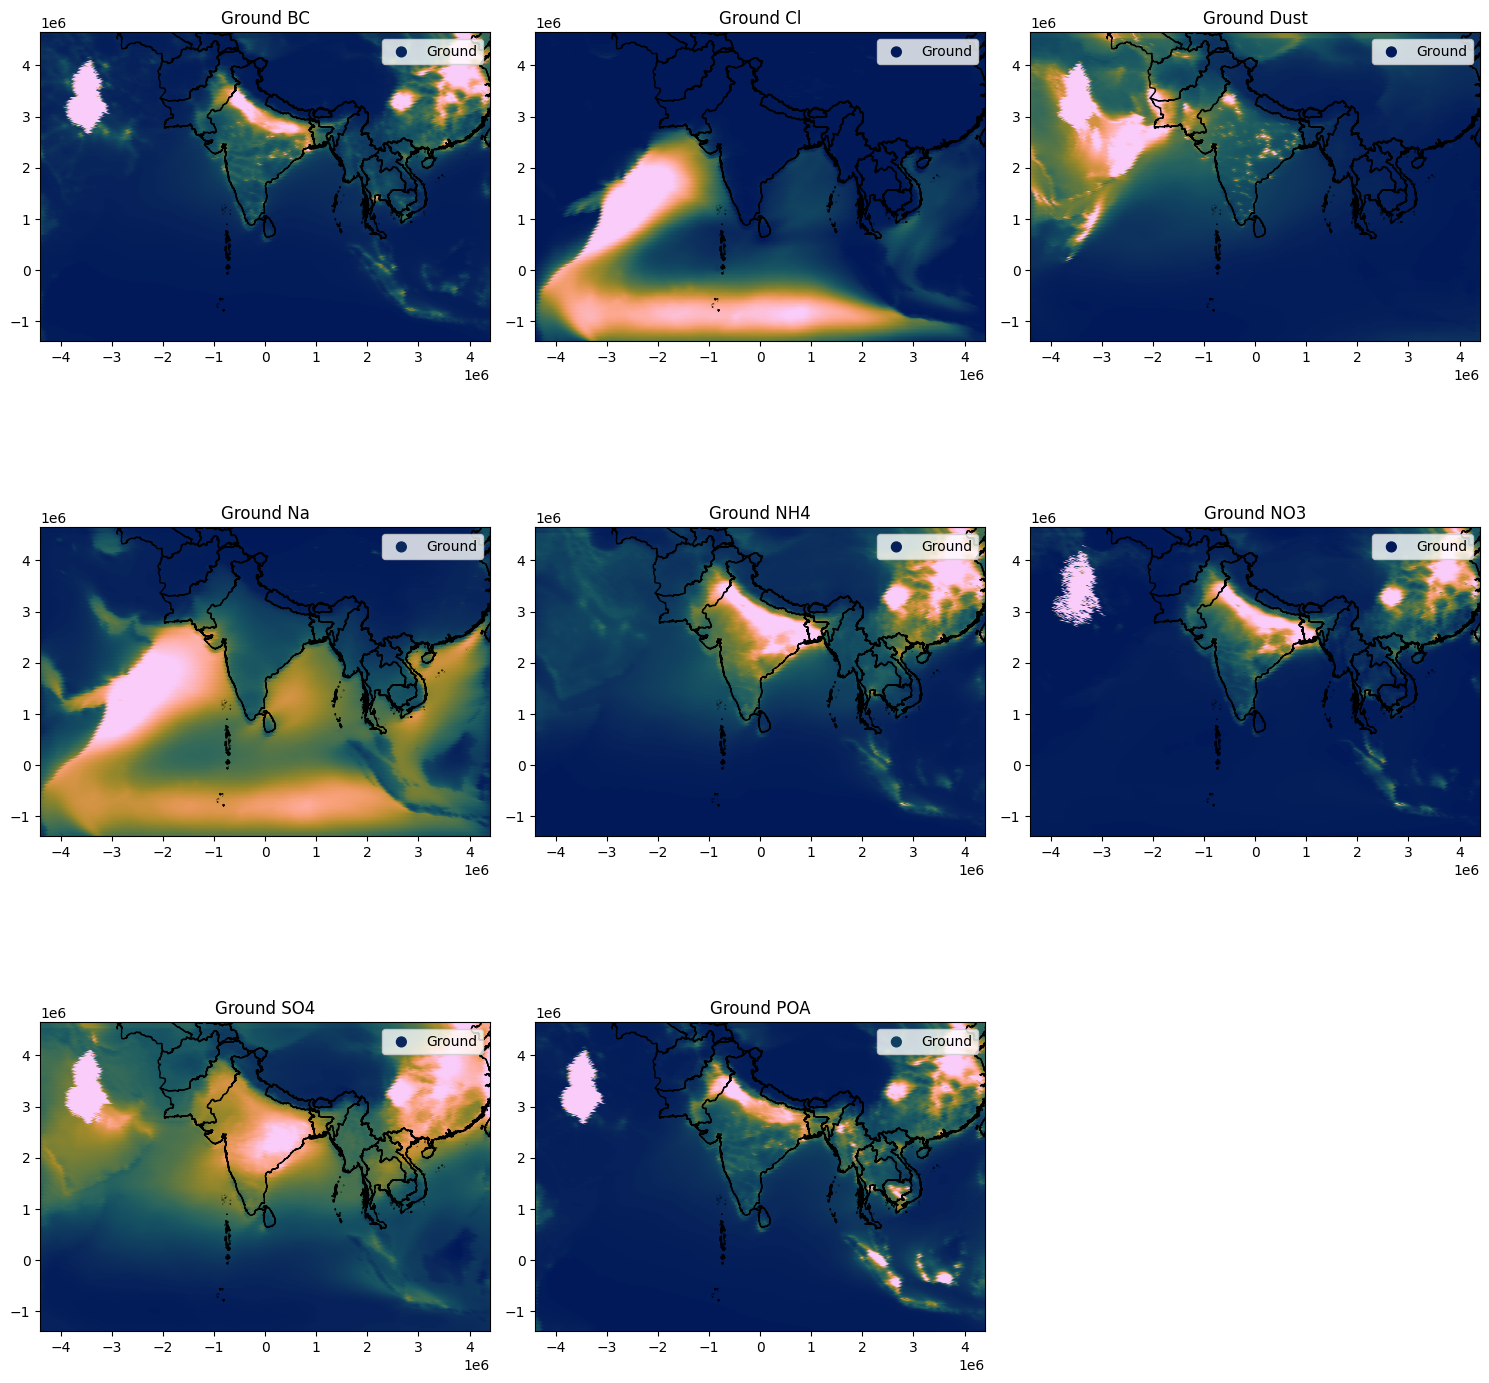

In [15]:
#Plot needs to be modified
borders_path = '../../PROJECTS/INDIA_WORLD_POP/data/asia/asia.shp'
input_path = 'Validation_Data/2017_WRF_ground_combined_ug_m3_mercator.shp'
pollutants = ['BC', 'Cl', 'Dust', 'Na', 'NH4', 'NO3', 'SO4', 'POA']

gdf = gpd.read_file(input_path)
gdf = gdf.to_crs(source_crs)

border_gdf = gpd.read_file(borders_path)
border_gdf = border_gdf.to_crs(source_crs)

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5)

for i, pollutant in enumerate(pollutants):
    # Calculate the subplot index (row and column)
    row = i // 3
    col = i % 3

    # Plot the pollutant points on the current subplot
    ground_layer = gdf
    ax = axes[row, col]

    percentile = np.percentile(ground_layer[pollutant], 97.5)
    ground_layer.plot(ax=ax, marker='o', markersize=50, label='Ground', column=pollutant, cmap=cm.batlow, vmax=percentile)
    ax.set_title(f"Ground {pollutant}")
    
    # Plot the country borders on the current subplot
    border_gdf.plot(ax=ax, edgecolor='black', color='none')

    # Set x and y limits based on point values for the current subplot
    x_min, y_min, x_max, y_max = gdf.geometry.total_bounds
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.legend(loc="upper right")

# Remove any empty subplots
for i in range(len(pollutants), 9):
    row = i // 3
    col = i % 3
    fig.delaxes(axes[row, col])

# Show the plot
plt.tight_layout()
plt.show()

# Create copy of files with energy at 200 meters

In [4]:
#Iterates through each file and reassign height of 220 and add height, diam, velocity, temp:
files = ['BC_PM2_5_2019', 'OC_PM2_5_2019', 'MM_PM2_5_2019', 'MM_PM2_5_2019', 'NH3_NOx_SOx_2019','VOC_2015']

for file in files:
    # Read the GeoDataFrame from the shapefile
    gdf = gpd.read_file(f'Processed_Emissions_2019_Pavitra/{file}_ground_elevated_mercator_kg_year.shp')

    # 1) Add new columns to the GeoDataFrame with float values
    gdf['diam'] = 0.0  # Replace 0.0 with the appropriate float value
    gdf['temp'] = 0.0  # Replace 0.0 with the appropriate float value
    gdf['velocity'] = 0.0  # Replace 0.0 with the appropriate float value

    # 2) Efficiently update values using boolean indexing
    mask = gdf['height'] == 100
    gdf.loc[mask, 'height'] = 220
    gdf.loc[mask, 'diam'] = 5.1
    gdf.loc[mask, 'velocity'] = 22.5
    gdf.loc[mask, 'temp'] = 453.0  # Make sure to use float values here as well

    # Save the modified GeoDataFrame to a new shapefile
    gdf.to_file(f'Processed_Emissions_2019_Pavitra/{file}_220_ground_elevated_mercator_kg_year.shp')

# Create copy of files with LCC projection and change name

In [7]:
# List of file names
files = ['BC_PM2_5_2019', 'OC_PM2_5_2019', 'MM_PM2_5_2019', 'MM_PM2_5_2019', 'NH3_NOx_SOx_2019',
         'VOC_2015', 'inline_dust_2017', 'BC_PM2_5_2019_220', 'OC_PM2_5_2019_220', 'MM_PM2_5_2019_220',
         'MM_PM2_5_2019_220', 'NH3_NOx_SOx_2019_220', 'VOC_2015_220']

# Suffix for the new file names
suffix = '_ground_elevated_lcc_kg_year.shp'

# Projection string for LCC
lcc_proj = "+proj=lcc +lat_1=33.000000 +lat_2=45.000000 +lat_0=40.000000 +lon_0=-97.000000 +x_0=0 +y_0=0 +a=6370997.000000 +b=6370997.000000 +to_meter=1"

for file in files:
    # Read the original GeoDataFrame
    gdf = gpd.read_file(f'Processed_Emissions_2019_Pavitra/{file}_ground_elevated_mercator_kg_year.shp')
    original_crs = gdf.crs
    print(f"Original CRS of {file}: {original_crs}")
    # Set the new CRS
    gdf.crs = lcc_proj
    # Save the GeoDataFrame with the new suffix
    gdf.to_file(f'Processed_Emissions_2019_Pavitra/LCC/{file}{suffix}')
    print(f"New CRS : {gdf.crs}")
    print(f"Converted and saved to {file}{suffix}")

Original CRS of BC_PM2_5_2019: PROJCS["unknown",GEOGCS["GCS_unknown",DATUM["D_unknown",SPHEROID["unknown",6370000,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mercator_2SP"],PARAMETER["standard_parallel_1",15],PARAMETER["central_meridian",80],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
New CRS : +proj=lcc +lat_1=33.000000 +lat_2=45.000000 +lat_0=40.000000 +lon_0=-97.000000 +x_0=0 +y_0=0 +a=6370997.000000 +b=6370997.000000 +to_meter=1 +type=crs
Converted and saved to BC_PM2_5_2019_ground_elevated_lcc_kg_year.shp
Original CRS of OC_PM2_5_2019: PROJCS["unknown",GEOGCS["GCS_unknown",DATUM["D_unknown",SPHEROID["unknown",6370000,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mercator_2SP"],PARAMETER["standard_parallel_1",15],PARAMETER["central_meridian",80],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northi

DriverError: Processed_Emissions_2019_Pavitra/inline_dust_2017_220_ground_elevated_mercator_kg_year.shp: No such file or directory

In [ ]:
# Repeat for Validation Dataset (This will make validation more straighforward)
files = ['2017_WRF_ground_combined_ug_m3_mercator.shp']

# Projection string for LCC
lcc_proj = "+proj=lcc +lat_1=33.000000 +lat_2=45.000000 +lat_0=40.000000 +lon_0=-97.000000 +x_0=0 +y_0=0 +a=6370997.000000 +b=6370997.000000 +to_meter=1"

for file in files:
    # Read the original GeoDataFrame
    gdf = gpd.read_file(f'Validation_Data/{file}')

    # Set the new CRS
    gdf.crs = lcc_proj

    # Save the GeoDataFrame with the new suffix
    gdf.to_file('Validation_Data/2017_WRF_ground_combined_ug_m3_lcc.shp')

# Overlap of Emissions files


In [ ]:
#Save files in synology
#Do Totals
#Overap files
#Analyse Pavitra files

# Tally of Emission files (LCC)

In [5]:
files = ['BC_PM2_5_2019_220', 'OC_PM2_5_2019_220', 'MM_PM2_5_2019_220',
         'MM_PM2_5_2019_220', 'NH3_NOx_SOx_2019_220', 'VOC_2015_220', 'inline_dust_2017']

suffix = '_ground_elevated_lcc_kg_year.shp'
# Define the columns you want to calculate the total sum for
columns_to_sum = ['NH3', 'NOx', 'SOx', 'VOC', 'PM2_5']
# Initialize a list to store the summary data
summary = []

# Iterate through the files
for file in files:
    # Read the GeoDataFrame from the shapefile
    gdf = gpd.read_file(f'Processed_Emissions_2019_Pavitra/LCC/{file}{suffix}')
    if file == 'inline_dust_2017':
        gdf['height']=0
    #groupby height
    grouped = gdf.groupby('height')

    # Iterate through height values (0 and 220)
    for height, group in grouped:
        row_count = group.shape[0]
        x_min = group.geometry.x.min()
        x_max = group.geometry.x.max()
        y_min = group.geometry.y.min()
        y_max = group.geometry.y.max()
        # Calculate the total sum, maximum, and minimum for each column within the group
        for col in columns_to_sum:
            if col in group.columns:
                summary_dict={}
                summary_dict['File'] = file
                summary_dict['Pollutant'] = col
                summary_dict['height'] = height
                summary_dict['n'] = row_count
                summary_dict['sum'] = group[col].sum()
                summary_dict['min'] = group[col].min()
                summary_dict['max'] = group[col].max()
                summary_dict['x_min'] = x_min
                summary_dict['x_max'] = x_max
                summary_dict['y_min'] = y_min
                summary_dict['y_max'] = y_max

                # Append the summary dictionary to the summary list
                summary.append(summary_dict)

# Create a DataFrame from the summary list
df_summary = pd.DataFrame(summary)

# Save the DataFrame as a CSV file
df_summary.to_csv('emissions_summary_points_lcc_240205.csv')

# Print or use the DataFrame as needed
df_summary

,File,Pollutant,height,n,sum,min,max,x_min,x_max,y_min,y_max
0,BC_PM2_5_2019_220,PM2_5,0,1739822,3.475263e+09,0.0,7.743825e+06,-4.402957e+06,4.429804e+06,-1.397175e+06,4.680135e+06
1,BC_PM2_5_2019_220,PM2_5,220,1739822,3.712621e+08,0.0,4.826548e+06,-4.402957e+06,4.429804e+06,-1.397175e+06,4.680135e+06


In [ ]:
df_summary=pd.read_csv('emissions_summary_points_lcc_240205.csv')

# Summary for Pavitra Emissions

In [26]:
#Modify for all file names
files = ['PM25_ground','PM25_elevated','BC_ground','OM_ground']

suffix = '_mercator_LLC.shp'
# Define the columns you want to calculate the total sum for
columns_to_sum = ['NH3', 'NOx', 'SOx', 'VOC', 'PM2_5']
# Initialize a list to store the summary data
summary = []
# Iterate through the files
for file in files:
    print(file)
    # Read the GeoDataFrame from the shapefile
    gdf = gpd.read_file(f'Processed_Emissions_2019_Pavitra/LCC/{file}{suffix}')
    if 'height' not in gdf.columns:
        gdf['height'] = 0
    #groupby height
    grouped = gdf.groupby('height')

    # Iterate through height values (0 and 220)
    for height, group in grouped:
        row_count = group.shape[0]
        # Store the bounds as separate variables
        x_min, y_min, x_max, y_max = gdf.geometry.total_bounds
        # Calculate the total sum, maximum, and minimum for each column within the group
        for col in columns_to_sum:
            if col in group.columns:
                summary_dict={}
                summary_dict['File'] = file
                summary_dict['Pollutant'] = col
                summary_dict['height'] = height
                summary_dict['n'] = row_count
                summary_dict['sum'] = group[col].sum()
                summary_dict['min'] = group[col].min()
                summary_dict['max'] = group[col].max()
                summary_dict['x_min'] = x_min
                summary_dict['x_max'] = x_max
                summary_dict['y_min'] = y_min
                summary_dict['y_max'] = y_max
                # Append the summary dictionary to the summary list
                summary.append(summary_dict)

# Create a DataFrame from the summary list
df_summary_iitb = pd.DataFrame(summary)

# Create a DataFrame from the summary list
df_summary_iitb= pd.DataFrame(summary)

# Save the DataFrame as a CSV file
df_summary_iitb.to_csv('emissions_IITB_lcc_240205.csv')

,File,Pollutant,height,n,sum,min,max,x_min,x_max,y_min,y_max
0,PM25_ground_mercator_LLC.shp,PM2_5,0,694722,1.439377e+10,0.000000,2.770919e+07,-2.298129e+06,2.180135e+06,-204215.745493,4.659155e+06
1,PM25_elevated_mercator_LLC.shp,PM2_5,220,694722,1.907392e+09,0.000000,1.720533e+08,-2.295444e+06,2.177450e+06,-201529.475402,4.655663e+06
2,BC_ground_mercator_LLC.shp,PM2_5,0,694722,1.648951e+09,0.000000,7.743791e+06,-2.298129e+06,2.180135e+06,-204215.745493,4.659155e+06
3,BC_elevated_mercator_LLC.shp,PM2_5,220,694722,1.008252e+08,0.000000,4.826548e+06,-2.295444e+06,2.177450e+06,-201529.475402,4.655663e+06
4,OM_ground_mercator_LLC.shp,PM2_5,0,694722,1.036506e+10,0.000000,5.070194e+06,-2.298129e+06,2.180135e+06,-204215.745493,4.659155e+06
5,OM_elevated_mercator_LLC.shp,PM2_5,220,694722,2.620141e+08,0.000000,1.079595e+07,-2.295444e+06,2.177450e+06,-201529.475402,4.655663e+06
6,MM_ground_mercator_LLC.shp,PM2_5,0,694722,2.379756e+09,0.000000,2.291209e+07,-2.298129e+06,2.180135e+06,-204215.745493,4.659155e+06
7,MM_elevated_mercator_LLC.shp,PM2_5,220,694722,1.544553e+09,0.000000,1.564308e+08,-2.295444e+06,2.177450e+06,-201529.475402,4.655663e+06
8,NH3_ground_mercator_LLC.shp,NH3,0,694722,1.801105e+10,0.000000,3.390110e+05,-2.298129e+06,2.180135e+06,-204215.745493,4.659155e+06
9,NH3_elevated_mercator_LLC.shp,NH3,220,694722,1.710517e+08,0.000000,3.072682e+05,-2.295444e+06,2.177450e+06,-201529.475402,4.655663e+06


# Chop Emissions and create summary

In [5]:
minx, miny, maxx, mayy = -2320000.0, -2200000.0, 2200000.0, 4700000.0

files = ['BC_PM2_5_2019_220', 'OC_PM2_5_2019_220', 'MM_PM2_5_2019_220',
         'MM_PM2_5_2019_220', 'NH3_NOx_SOx_2019_220', 'VOC_2015_220', 'inline_dust_2017']

suffix = '_ground_elevated_lcc_kg_year.shp'

# Iterate through the files
for file in files:
    # Read the GeoDataFrame from the shapefile
    gdf = gpd.read_file(f'Processed_Emissions_2019_Pavitra/LCC/{file}{suffix}')
    # Use the cx indexer to clip the GeoDataFrame to the bounding box
    cropped_gdf = gdf.cx[minx:maxx, miny:mayy]
    # Save the GeoDataFrame with the new suffix
    cropped_gdf.to_file(f'Processed_Emissions_2019_Pavitra/LCC/Cropped_{file}{suffix}')
    print('file completed')


file completed
file completed
file completed
file completed
file completed
file completed
file completed


In [6]:
files = ['Cropped_BC_PM2_5_2019_220', 'Cropped_OC_PM2_5_2019_220', 'Cropped_MM_PM2_5_2019_220',
         'Cropped_MM_PM2_5_2019_220', 'Cropped_NH3_NOx_SOx_2019_220', 'Cropped_VOC_2015_220', 'Cropped_inline_dust_2017']
suffix = '_ground_elevated_lcc_kg_year.shp'
# Define the columns you want to calculate the total sum for
columns_to_sum = ['NH3', 'NOx', 'SOx', 'VOC', 'PM2_5']
# Initialize a list to store the summary data
summary = []
# Iterate through the files
for file in files:
    print(file)
    # Read the GeoDataFrame from the shapefile
    gdf = gpd.read_file(f'Processed_Emissions_2019_Pavitra/LCC/{file}{suffix}')
    if 'height' not in gdf.columns:
        gdf['height'] = 0
    #groupby height
    grouped = gdf.groupby('height')

    # Iterate through height values (0 and 220)
    for height, group in grouped:
        row_count = group.shape[0]
        # Store the bounds as separate variables
        x_min, y_min, x_max, y_max = gdf.geometry.total_bounds
        # Calculate the total sum, maximum, and minimum for each column within the group
        for col in columns_to_sum:
            if col in group.columns:
                summary_dict={}
                summary_dict['File'] = file
                summary_dict['Pollutant'] = col
                summary_dict['height'] = height
                summary_dict['n'] = row_count
                summary_dict['sum'] = group[col].sum()
                summary_dict['min'] = group[col].min()
                summary_dict['max'] = group[col].max()
                summary_dict['x_min'] = x_min
                summary_dict['x_max'] = x_max
                summary_dict['y_min'] = y_min
                summary_dict['y_max'] = y_max
                # Append the summary dictionary to the summary list
                summary.append(summary_dict)


# Create a DataFrame from the summary list
df_summary_cropped = pd.DataFrame(summary)

# Save the DataFrame as a CSV file
df_summary_cropped.to_csv('cropped_emissions_summary_points_lcc_240205.csv')

Cropped_BC_PM2_5_2019_220
Cropped_OC_PM2_5_2019_220
Cropped_MM_PM2_5_2019_220
Cropped_MM_PM2_5_2019_220
Cropped_NH3_NOx_SOx_2019_220
Cropped_VOC_2015_220
Cropped_inline_dust_2017


In [7]:
df_summary_cropped

,File,Pollutant,height,n,sum,min,max,x_min,x_max,y_min,y_max
0,Cropped_BC_PM2_5_2019_220,PM2_5,0,889994,1.666006e+09,0.000000,7.743825e+06,-2.319606e+06,2.196109e+06,-1.397175e+06,4.680135e+06
1,Cropped_BC_PM2_5_2019_220,PM2_5,220,889994,1.019967e+08,0.000000,4.826548e+06,-2.319606e+06,2.196109e+06,-1.397175e+06,4.680135e+06
2,Cropped_OC_PM2_5_2019_220,PM2_5,0,889994,1.044272e+10,0.000000,5.074646e+06,-2.319606e+06,2.196109e+06,-1.397175e+06,4.680135e+06
3,Cropped_OC_PM2_5_2019_220,PM2_5,220,889994,2.717142e+08,0.000000,1.079595e+07,-2.319606e+06,2.196109e+06,-1.397175e+06,4.680135e+06
4,Cropped_MM_PM2_5_2019_220,PM2_5,0,889994,2.382233e+09,0.000000,2.291210e+07,-2.319606e+06,2.196109e+06,-1.397175e+06,4.680135e+06
5,Cropped_MM_PM2_5_2019_220,PM2_5,220,889994,1.544552e+09,0.000000,1.564308e+08,-2.319606e+06,2.196109e+06,-1.397175e+06,4.680135e+06
6,Cropped_MM_PM2_5_2019_220,PM2_5,0,889994,2.382233e+09,0.000000,2.291210e+07,-2.319606e+06,2.196109e+06,-1.397175e+06,4.680135e+06
7,Cropped_MM_PM2_5_2019_220,PM2_5,220,889994,1.544552e+09,0.000000,1.564308e+08,-2.319606e+06,2.196109e+06,-1.397175e+06,4.680135e+06
8,Cropped_NH3_NOx_SOx_2019_220,NH3,0,889994,1.811325e+10,0.000000,3.377330e+05,-2.319606e+06,2.196109e+06,-1.397175e+06,4.680135e+06
9,Cropped_NH3_NOx_SOx_2019_220,NOx,0,889994,1.602365e+10,4.856938,7.897543e+07,-2.319606e+06,2.196109e+06,-1.397175e+06,4.680135e+06
